In [ ]:
!pip install jcopdl
#!pip install split-folders

In [ ]:
#!unrar x "/content/drive/MyDrive/belajar python/case study/forest fire/image.rar" "/content/drive/MyDrive/belajar python/case study/forest fire/"

In [2]:
#import splitfolders

import torch
from torchvision.models import mobilenet_v3_large , MobileNet_V3_Large_Weights
from torch import nn, optim
from jcopdl.callback import Callback, set_config

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
#splitfolders.ratio("/content/drive/MyDrive/belajar python/case study/forest fire/image",output = "/content/drive/MyDrive/belajar python/case study/forest fire/img/",seed = 42,ratio = (0.8,0.2))

Copying files: 415 files [00:03, 106.60 files/s]


In [3]:
mnet_weight = MobileNet_V3_Large_Weights.IMAGENET1K_V2

bs = 64
crop_size = 254

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(crop_size,scale = (0.8,1)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
])


train_set = datasets.ImageFolder("/content/drive/MyDrive/belajar python/case study/forest fire/img/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/drive/MyDrive/belajar python/case study/forest fire/img/val", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [ ]:
label2cat = test_set.classes
print(label2cat)

['fire', 'no_fire']


In [12]:
from collections import Counter
print(dict(Counter(train_set.targets)))

{0: 167, 1: 164}


In [13]:
print(dict(Counter(test_set.targets)))

{0: 42, 1: 42}


In [14]:
train_set

Dataset ImageFolder
    Number of datapoints: 331
    Root location: /content/drive/MyDrive/belajar python/case study/forest fire/img/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(254, 254), scale=(0.8, 1), ratio=(0.75, 1.3333), interpolation=bilinear)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

In [ ]:
class ForestFireRecognition(nn.Module):
    def __init__(self):
        super().__init__()
        self.mnet = model = mobilenet_v3_large(mnet_weight)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Hardswish(),
            nn.Linear(960,1280),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(1280,2),
            nn.LogSoftmax(1)
        )
    def forward(self,x) :
        x = self.mnet(x)
        return x

    def fc_params(self):
        return self.mnet.classifier.parameters()

    def freeze(self) :
        for param in self.mnet.parameters():
            param.requires_grad = False 

    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [ ]:
config = set_config({
    "batch_size" : bs,
    "crop_size" : crop_size
})

## Phase 1 , Adaptation (standard learning rate, small early stop)

In [ ]:
model = ForestFireRecognition().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.fc_params(), lr=0.001)
callback = Callback(model, config, outdir="model",early_stop_patience=2)

In [ ]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Test: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]



Epoch     1
Train_cost  = 0.5074 | Test_cost  = 0.4955 | Train_score = 0.7946 | Test_score = 0.7500 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]



Epoch     2
Train_cost  = 0.2919 | Test_cost  = 0.3863 | Train_score = 0.8822 | Test_score = 0.8214 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]



Epoch     3
Train_cost  = 0.2167 | Test_cost  = 0.3052 | Train_score = 0.9003 | Test_score = 0.8571 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]



Epoch     4
Train_cost  = 0.2200 | Test_cost  = 0.2480 | Train_score = 0.9033 | Test_score = 0.8929 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]



Epoch     5
Train_cost  = 0.1545 | Test_cost  = 0.2340 | Train_score = 0.9275 | Test_score = 0.9048 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]



Epoch     6
Train_cost  = 0.1599 | Test_cost  = 0.2120 | Train_score = 0.9245 | Test_score = 0.9167 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]



Epoch     7
Train_cost  = 0.1614 | Test_cost  = 0.2258 | Train_score = 0.9456 | Test_score = 0.9048 |
==> EarlyStop patience =  1 | Best test_score: 0.9167


Test: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]



Epoch     8
Train_cost  = 0.1598 | Test_cost  = 0.2196 | Train_score = 0.9335 | Test_score = 0.9286 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]



Epoch     9
Train_cost  = 0.1244 | Test_cost  = 0.2196 | Train_score = 0.9456 | Test_score = 0.9286 |
==> EarlyStop patience =  1 | Best test_score: 0.9286


Test: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]



Epoch    10
Train_cost  = 0.1191 | Test_cost  = 0.2220 | Train_score = 0.9486 | Test_score = 0.9167 |
==> EarlyStop patience =  2 | Best test_score: 0.9286
==> Execute Early Stopping at epoch: 10 | Best test_score: 0.9286
==> Best model is saved at model


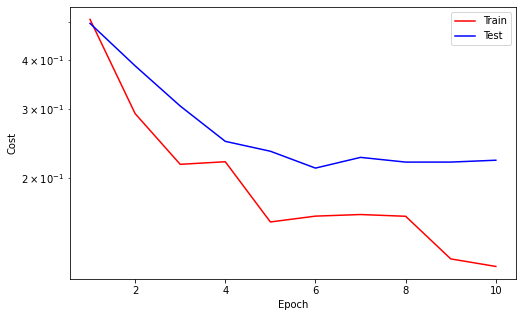

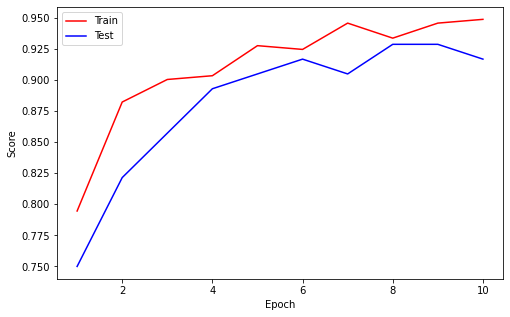

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Phase 2 , Fine Tuning

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

callback.reset_early_stop()
callback.early_stop_patience = 5

Test: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]



Epoch    11
Train_cost  = 0.1374 | Test_cost  = 0.2089 | Train_score = 0.9486 | Test_score = 0.9286 |
==> EarlyStop patience =  1 | Best test_score: 0.9286


Test: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]



Epoch    12
Train_cost  = 0.1211 | Test_cost  = 0.1981 | Train_score = 0.9486 | Test_score = 0.9286 |
==> EarlyStop patience =  2 | Best test_score: 0.9286


Test: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]



Epoch    13
Train_cost  = 0.1135 | Test_cost  = 0.1880 | Train_score = 0.9668 | Test_score = 0.9286 |
==> EarlyStop patience =  3 | Best test_score: 0.9286


Test: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]



Epoch    14
Train_cost  = 0.1297 | Test_cost  = 0.1786 | Train_score = 0.9547 | Test_score = 0.9286 |
==> EarlyStop patience =  4 | Best test_score: 0.9286


Test: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]



Epoch    15
Train_cost  = 0.0920 | Test_cost  = 0.1724 | Train_score = 0.9728 | Test_score = 0.9405 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]



Epoch    16
Train_cost  = 0.1071 | Test_cost  = 0.1655 | Train_score = 0.9517 | Test_score = 0.9524 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]



Epoch    17
Train_cost  = 0.1145 | Test_cost  = 0.1582 | Train_score = 0.9547 | Test_score = 0.9405 |
==> EarlyStop patience =  1 | Best test_score: 0.9524


Test: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]



Epoch    18
Train_cost  = 0.0886 | Test_cost  = 0.1516 | Train_score = 0.9789 | Test_score = 0.9643 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]



Epoch    19
Train_cost  = 0.0765 | Test_cost  = 0.1470 | Train_score = 0.9698 | Test_score = 0.9643 |
==> EarlyStop patience =  1 | Best test_score: 0.9643


Test: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]



Epoch    20
Train_cost  = 0.0929 | Test_cost  = 0.1410 | Train_score = 0.9698 | Test_score = 0.9643 |


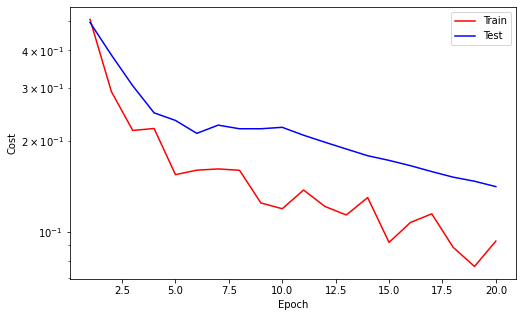

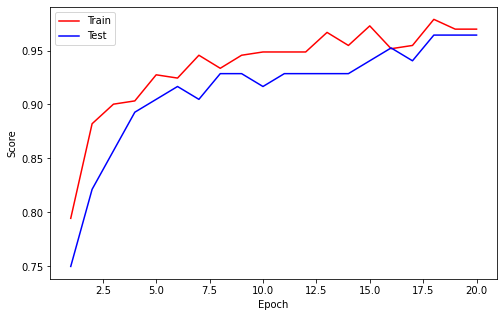

==> EarlyStop patience =  2 | Best test_score: 0.9643


Test: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]



Epoch    21
Train_cost  = 0.0718 | Test_cost  = 0.1361 | Train_score = 0.9758 | Test_score = 0.9643 |
==> EarlyStop patience =  3 | Best test_score: 0.9643


Test: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]



Epoch    22
Train_cost  = 0.0950 | Test_cost  = 0.1310 | Train_score = 0.9637 | Test_score = 0.9643 |
==> EarlyStop patience =  4 | Best test_score: 0.9643


Test: 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]



Epoch    23
Train_cost  = 0.0756 | Test_cost  = 0.1243 | Train_score = 0.9728 | Test_score = 0.9762 |


Test: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]



Epoch    24
Train_cost  = 0.0738 | Test_cost  = 0.1199 | Train_score = 0.9789 | Test_score = 0.9881 |


Test: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]



Epoch    25
Train_cost  = 0.0920 | Test_cost  = 0.1165 | Train_score = 0.9547 | Test_score = 0.9762 |
==> EarlyStop patience =  1 | Best test_score: 0.9881


Test: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]



Epoch    26
Train_cost  = 0.0691 | Test_cost  = 0.1127 | Train_score = 0.9668 | Test_score = 0.9881 |
==> EarlyStop patience =  2 | Best test_score: 0.9881


Test: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]



Epoch    27
Train_cost  = 0.0921 | Test_cost  = 0.1105 | Train_score = 0.9789 | Test_score = 0.9762 |
==> EarlyStop patience =  3 | Best test_score: 0.9881


Test: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]



Epoch    28
Train_cost  = 0.1113 | Test_cost  = 0.1082 | Train_score = 0.9577 | Test_score = 0.9762 |
==> EarlyStop patience =  4 | Best test_score: 0.9881


Test: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]



Epoch    29
Train_cost  = 0.0872 | Test_cost  = 0.1067 | Train_score = 0.9698 | Test_score = 0.9762 |
==> EarlyStop patience =  5 | Best test_score: 0.9881
==> Execute Early Stopping at epoch: 29 | Best test_score: 0.9881
==> Best model is saved at model


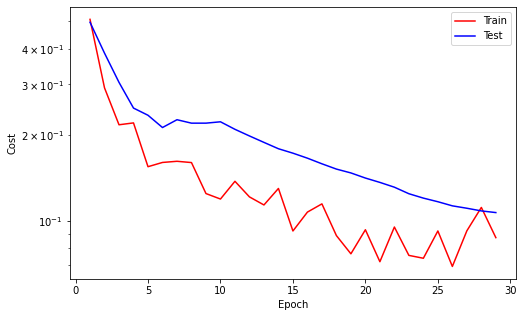

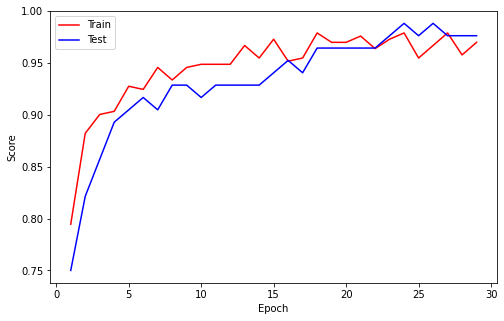

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [ ]:
itr = iter(testloader)

In [ ]:
feature,target = next(itr)
feature , target = feature.to(device), target.to(device)

with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)

preds

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

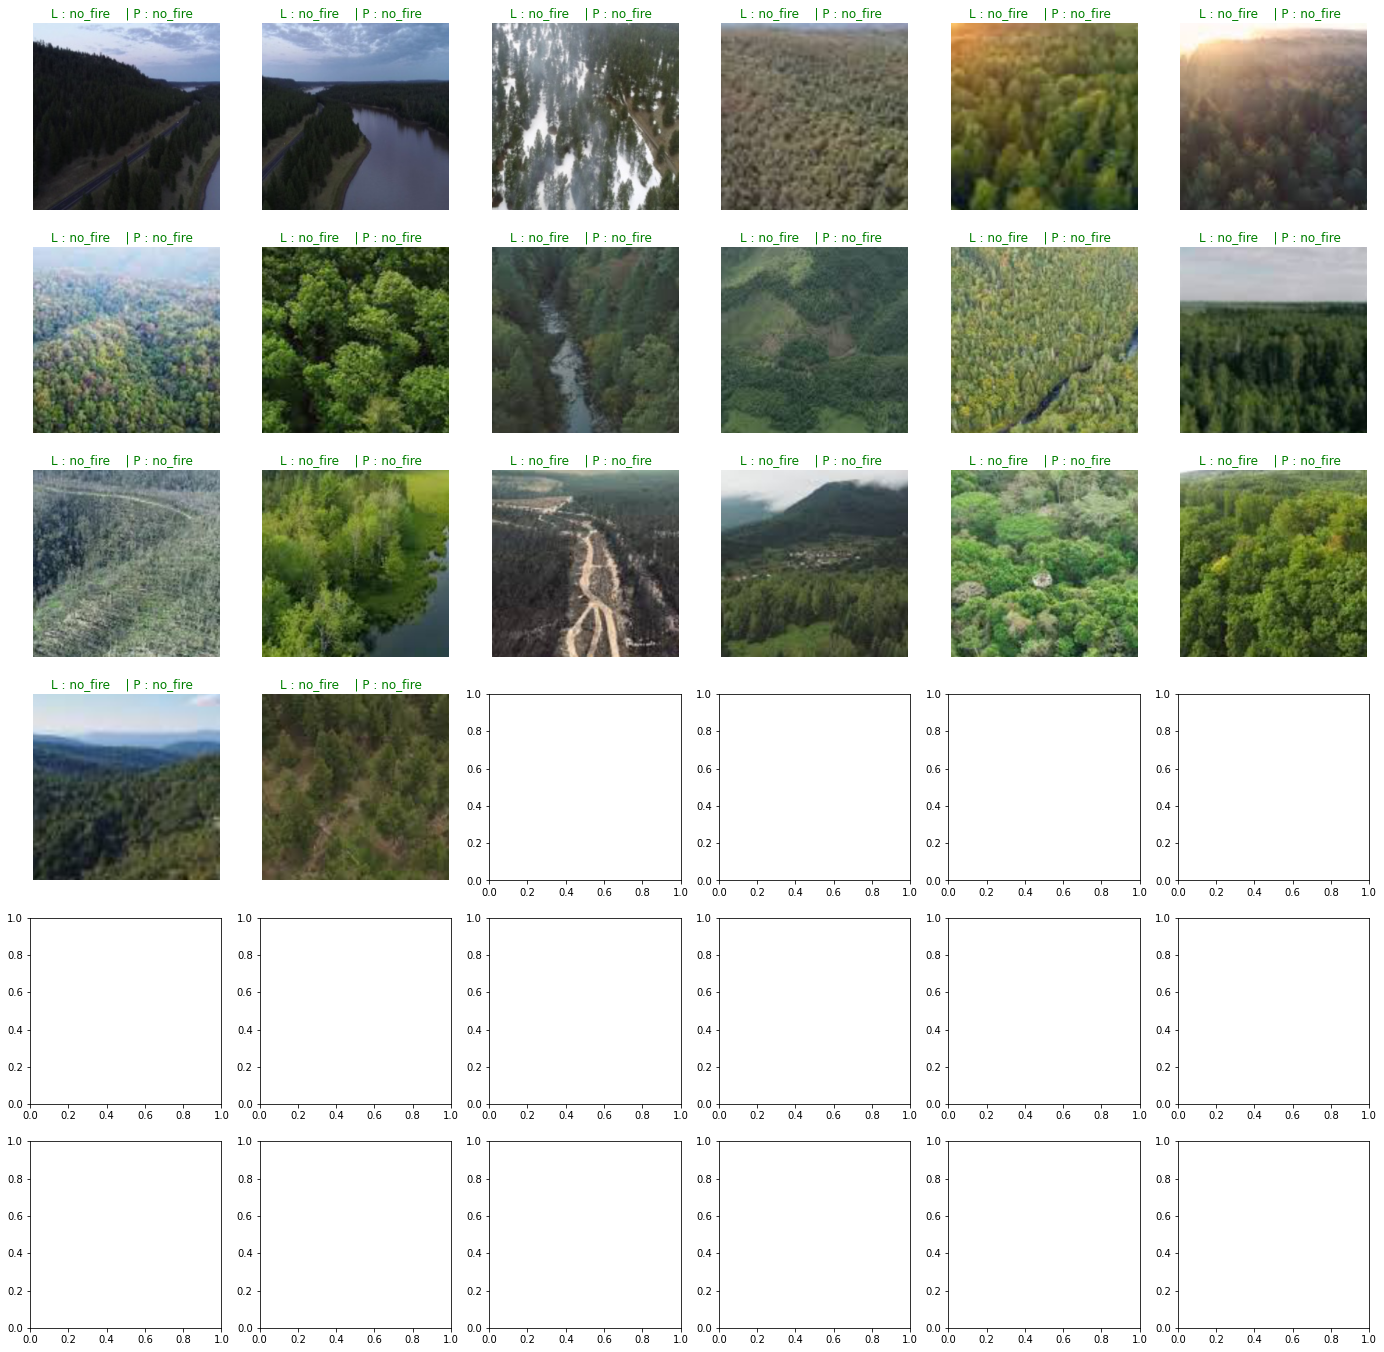

In [ ]:
fig,axes = plt.subplots(6,6,figsize = (24,24))
for image , label, pred, ax in zip(feature,target,preds,axes.flatten()):
  ax.imshow(image.permute(1,2,0).cpu())
  font = {"color" : "r"} if label != pred else {"color" : "g"}
  label,pred = label2cat[label.item()] , label2cat[pred.item()]
  ax.set_title(f"L : {label}    | P : {pred}  ",  fontdict = font )
  ax.axis("off");

In [ ]:

from google.colab import files

uploaded = files.upload()
 
for fn in uploaded.keys():
 
    path = fn
    img = Image.open(path)
    
    imgplot = plt.imshow(img)
    img_trans = test_transform(img)
    img_trans = img_trans.to(device)
    img_trans = img_trans[None,:]
 
    with torch.no_grad():
        model.eval()
        out = model(img_trans) 
        pred = label2cat[out.argmax(1)[0]]
    print(fn)
    plt.title(pred)
    plt.axis("off")

KeyboardInterrupt: ignored